**<h1><center>Lab-6-Report </center></h1>**

**<h1><center>EE5175: Image Signal Processing </center></h1>**


<h4><center>Under the guidence of </center></h4>
<h4><center>Prof. AN.Rajagopalan </center></h4>

<center>By EE21S048</center>

<h9>Date of submission: 11-03-2022<h9>

---

#**Shape from focus**


*   The amount of blur due to optical defocussing depends on the distance between camera and
scene.
*   Hence it is possible to use blur as a cue to determine the depth of a particular point in the
scene.

**Import the Libraries:**

In [21]:
from numpy import *
import sys
import cv2
import matplotlib.pyplot as plt
from scipy.io import loadmat
import matplotlib.cm as cm

In this experiment,
*    we are given a set of images which are captured using different camera lens settings, thus resulting in different degrees of optical blur. 
*   Using these images we have to determine the depth of each pixel in the image using the shape from focus (SFF) algorithm.

**Read the mat file:**

In [22]:
mat1= loadmat('stack.mat')         # read the stack.mat file
N= int(mat1['numframes'])          # get the numframes variables
frames = {}
#store the images in a dictionary for easier access later
for key in mat1.keys():
    if key[:5] == 'frame':
        frames[int(key[5:])] = mat1[key]

**Display a image from the stack:**

100


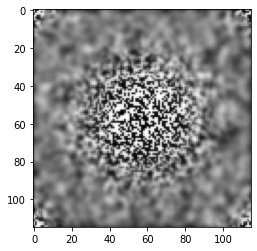

In [23]:
print(N)                           #number of frames in the given stack
plt.imshow(frames[100],'gray')

**Partial Double derivatives:**

 
*   Use sum-modified Laplacian (SML) operator as focus measure and ∆d = 50.50.


In [19]:
d=50.50
q_value=[0,1,2]
lx = array([[0,  0, 0],[1, -2, 1],[0,  0, 0]])
ly = array([[0,  1, 0],[0, -2, 0],[0,  1, 0]])

##**Convolution:**


In [5]:
def conv(img,kernel):
    width, height = shape(img)
    k_size = len(kernel)
    t=k_size//2 
    filtered_image = zeros((width-2*t, height-2*t))
    for i in range(t, width-t):
        for j in range(t, height-t):
            # extract image patch
            patch = img[i-t:i+t+1, j-t:j+t+1]
            # multiply image patch with the kernel, sum and store
            filtered_image[i-t, j-t] = sum(patch*kernel)
    return filtered_image

##**Finding Sharp Image:**


---
**Modified Laplacian(ML):**

It is defined as
$$ ML=|I_{xx}|+|I_{yy}|$$

where 
$I_{xx}$ and 
$I_{yy}$ are the discrete 2D double derivatives of the image. Before calculating the ML, the image is zero padded as needed and  convolution is performed.

**Sum Modified Laplacian(SML):**

Given an image and a given value of q, its SML at pixel (x,y) is defined as
$$
SML(x,y)=∑_{i=-q} ^{i=q}∑_{j=-q} ^{i=q} ML(x+i,y+j)
$$

Using a larger $q$ is more robust but can merge depth information from nearby pixels. 

For a pixel, assume the frame which has the maximum  at that pixel to be the frame in focus and use it for depth estimation. 

---

*   Observe the output 3D structure for q = 0, 1 and 2, where q is the size of the neighbourhood for the SML window as defined in class.

*   Now lets find sharp image for one q value:

In [7]:
q=1

width,height=frames[1].shape
stacked=zeros((width,height,N))

for i in range(N):
  img=frames[i+1]
  k = 2*q+1
  kernel=ones((k,k))
  p=q+1
  img_padded =zeros((width+2*p, height+2*p))
  img_padded[p:-p, p:-p] = img
  I_xx = conv(img_padded, lx)
  I_yy = conv(img_padded, ly)
  ML=abs(I_xx)+abs(I_yy)
  SML=conv(ML,kernel)

  stacked[:, :, i] = SML

max_shaprness_frames=argmax(stacked, axis=2)
depth= max_shaprness_frames*d
sharp_image =zeros((width, height))
for i in range(width):
  for j in range(height):
    frame = max_shaprness_frames[i, j]+1
    sharp_image[i, j] = frames[frame][i, j]


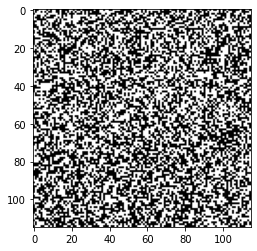

In [8]:
plt.imshow(sharp_image, 'gray')
plt.show()



*   Lets find sharp images for different q values.



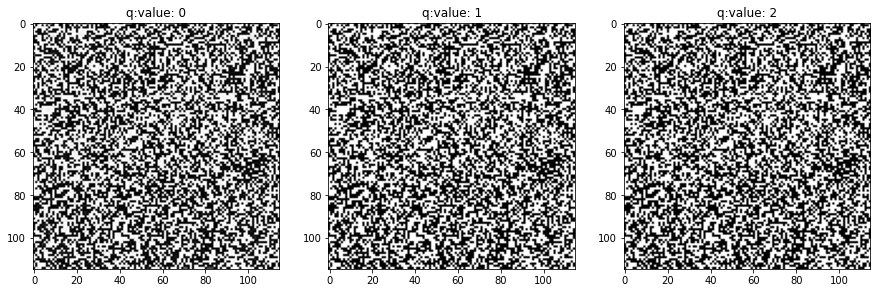

In [9]:
fig=plt.figure(figsize=(15,10))
axes=[]
depths={}
Maxs={}
qs={}
q_value=[0,1,2]
length=len(q_value)
for l in range(length):
  q=q_value[l]
  width,height=frames[1].shape
  stacked=zeros((width,height,N))

  for i in range(N):
    img=frames[i+1]
    k = 2*q+1
    kernel=ones((k,k))
    p=q+1
    img_padded =zeros((width+2*p, height+2*p))
    img_padded[p:-p, p:-p] = img

    I_xx = conv(img_padded, lx)
    I_yy = conv(img_padded, ly)
    ML=abs(I_xx)+abs(I_yy)
    SML=conv(ML,kernel)
    stacked[:, :, i] = SML

  max_shaprness_frames=argmax(stacked, axis=2)

  depth= max_shaprness_frames*d
  depths[l]=depth
  Maxs[l]=max_shaprness_frames
  sharp_img =zeros((width, height))

  for i in range(width):
    for j in range(height):
      frame = max_shaprness_frames[i, j]+1
      sharp_img[i, j] = frames[frame][i, j]
  
  qs[l]=sharp_img
  axes.append(fig.add_subplot(1,3,l+1))
  subplot_title=("q:value: "+str(q))
  axes[-1].set_title(subplot_title)
  plt.imshow(sharp_img,'gray')



##**Display the 3D structure of the scene using the calculated depth values.**

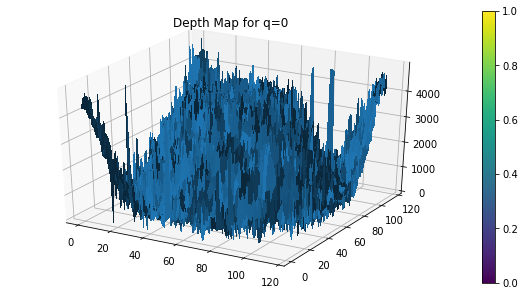

In [10]:
#plt.scatter(depth)
x, y = shape(frames[1])
X, Y = meshgrid(arange(x)+1, arange(y)+1)
fig = plt.figure(figsize=(10,5))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, depths[0], linewidth=0, antialiased=False)
title = rf"Depth Map for q=0"
plt.title(title)
fig.colorbar(surf)
plt.show()


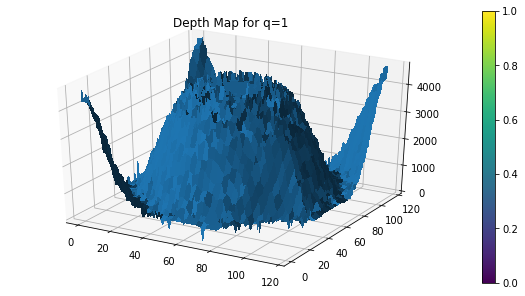

In [11]:
fig = plt.figure(figsize=(10,5))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, depths[1], linewidth=0, antialiased=False)
title = rf"Depth Map for q=1"
plt.title(title)
fig.colorbar(surf)
plt.show()

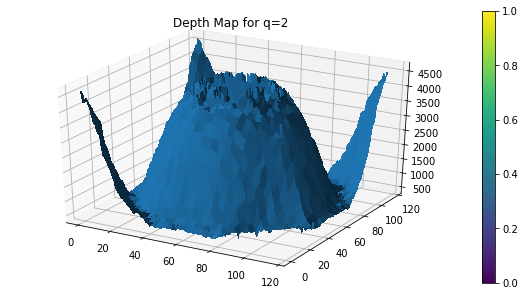

In [13]:
fig = plt.figure(figsize=(10,5))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, depths[2], linewidth=0, antialiased=False)
title = rf"Depth Map for q=2"
plt.title(title)
fig.colorbar(surf)
plt.show()

##**Conclusion:**


*   As the q value increases, the kernel size increases and we get smoother depth values.

*   The sharp images look almost similar with different kernel sizes.
*   The amount of blur due to optical defocussing depends on the distance between camera and scene. Hence it is possible to use blur as a cue to determine the depth of a particular point in the scene.
*   Thus we have found depth of image with the help of optical blur of the image and SFF algorithm.

*   Hence, we can say that, blur in the image can also make new sense.

